In [54]:
import Pkg; Pkg.add("DataFrames")
Pkg.add("CSV")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


Import libraries that will be useful to us:

- CSV: Used to read the adjacency list CSV file
- LinearAlgebra: Used to calculate transposes, Frobenius norms, etc.
- Statistics: Used to calculate MSE for testing

In [55]:
using CSV
using LinearAlgebra
using Statistics

#### Helper function that converts CSV file into an adjacency matrix
These helper functions are used to convert graphs stored in a CSV file into matrices.
This is useful for reading larger graphs stored in separate files that otherwise would be difficult to hard-code into the Julia program.

As an example, a CSV file has the following structure. It is an adjacency list but in CSV format
```
3
1, 3
1, 2, 3
```
So row 1 (the first node) is connected to the 3rd node only.

Row 2 (the second node) is connected to both the 1st and 3rd nodes.

Row 3 (the third node) is connected to the 1st, 2nd, and 3rd nodes.

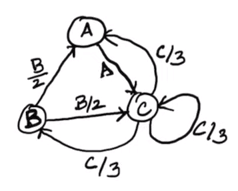

So the resulting adjacency matrix would be:
```
0 1 1
0 0 1
1 1 1
```

In [56]:
function csv_to_adjacency_matrix(file_path::String)
    # Read the CSV file
    # The empty rows are nodes with no connections. We still want to include those, but they will have
    # little to no impact in ranking importance.
    csv_file = CSV.File(file_path, header=false, silencewarnings=true, ignoreemptyrows=false)

    adjacency_matrix = zeros(Float64, length(csv_file), length(csv_file))

    # Iterate over each row
    for (node, row) in enumerate(csv_file)
        # Iterate over each field in the row
        for field in row
            if !ismissing(field)
                adjacency_matrix[field, node] = 1
            end
        end
    end

    return adjacency_matrix
end

csv_to_adjacency_matrix (generic function with 1 method)

#### Helper function that converts adjacency matrix into a Markov matrix

Normalizes all the columns so the sum of their probabilities equals 1.

For example, the previous adjacency matrix becomes the following Markov matrix:
```
 0.0  0.5  0.333333
 0.0  0.0  0.333333
 1.0  0.5  0.333333
 ```

In [57]:
function normalize_columns(file_path::String)
    # Create a copy of the matrix to avoid modifying the original
    normalized_matrix = csv_to_adjacency_matrix(file_path)
    matrix = copy(normalized_matrix)

    # Get the number of columns
    num_columns = size(matrix, 2)

    for col in 1:num_columns
        # Calculate the sum of the column
        col_sum = sum(matrix[:, col])

        # Avoid division by zero
        if col_sum != 0
            # Normalize the column
            normalized_matrix[:, col] .= matrix[:, col] ./ col_sum
        end
    end

    return normalized_matrix
end

normalize_columns (generic function with 1 method)

In [85]:
base_path = "/home/jose/Documents/CMU/21241/final-project/dummy-graphs/"

# Concat strings in Julia with *
markov_matrix = normalize_columns(base_path * "large-graph-1000.csv")
adjacency_matrix = csv_to_adjacency_matrix(base_path * "large-graph-1000.csv")

markov_matrix

1000×1000 Matrix{Float64}:
 0.0         0.00105597  0.0         …  0.00109051  0.0       0.00111235
 0.00118624  0.0         0.00225225     0.00109051  0.0       0.00111235
 0.00118624  0.00105597  0.0            0.00109051  0.0       0.00111235
 0.00118624  0.00105597  0.0            0.00109051  0.0       0.00111235
 0.00118624  0.00105597  0.0            0.00109051  0.0       0.00111235
 0.00118624  0.00105597  0.0         …  0.00109051  0.0       0.0
 0.00118624  0.00105597  0.0            0.00109051  0.0       0.00111235
 0.00118624  0.00105597  0.00225225     0.00109051  0.0       0.0
 0.00118624  0.00105597  0.0            0.00109051  0.010989  0.00111235
 0.0         0.00105597  0.00225225     0.00109051  0.0       0.00111235
 0.0         0.00105597  0.0         …  0.00109051  0.010989  0.0
 0.0         0.00105597  0.0            0.00109051  0.0       0.00111235
 0.00118624  0.00105597  0.0            0.00109051  0.0       0.00111235
 ⋮                                   ⋱       

Below, we create the PageRank algoritm with a dampening factor. These are their arguments:

- markov_matrix: The Markov matrix of the random walker.
- dampingFactor: A Float value between 0 and 1
- tol: The tolerance -- is correlated to how many iterations we want the algorithm to run

In [59]:
# This function does not modify the input markov matrix, so we don't need to make a copy within the function
function dampedPageRank(markov_matrix::Matrix{Float64}, dampingFactor, tol::Float64 = 1e-6)
    n = size(markov_matrix, 1)
    r = fill(1.0 / n, n)

    teleport = (1.0 - dampingFactor) / n
    iteration = 0
    delta = tol

    # Iteratively compute the PageRank
    while delta >= tol
        r_new = dampingFactor * (markov_matrix * r) .+ teleport
        # Calculate Frobenius norm
        delta = norm(r_new - r, 1)
        r = r_new
    end

    return r
end

dampedPageRank (generic function with 2 methods)

Below, assume an initial vector where surfers are distributed evenly among the nodes. Then find the steady state vector to find
distribution of all surfers among the states

In [83]:
function findStateProbabilities(markovMatrix::Matrix{Float64}; tol::Float64=1e-6)
    n = size(markovMatrix, 2)
    surfDistribution = fill(1/n, n)
    newSurfers = zeros(n)
    change = Inf # Theoretically infinite at the start

    while surfDistribution != newSurfers
        # newSurgers = markovMatrix .* surfDistribution
        mul!(newSurfers, markovMatrix, surfDistribution)
        change = norm(newSurfers - surfDistribution)  # Convergence check
        surfDistribution .= newSurfers
    end

    return surfDistribution
end

# function findStateProbabilities(newMarkovMatrix::Matrix{Float64})
#     copiedMarkov = copy(newMarkovMatrix)
#     surfDistribution = []
#     lengthMarkov = size(copiedMarkov, 2)
#     startingProbs = 1 / lengthMarkov
#     for _ in 1:lengthMarkov
#         push!(surfDistribution, startingProbs)
#     end
#     newSurfers = zeros(lengthMarkov)
#     while surfDistribution != newSurfers
#         newSurfers = copiedMarkov * surfDistribution
#         surfDistribution .= newSurfers
#     end
#     return surfDistribution
# end

findStateProbabilities (generic function with 2 methods)

Below is the HITS algoirthm. It calculates the authority scores and hub scores.

In [45]:
function hits_algorithm(hitsMatrix::Matrix{Float64})
    adjacencyMatrixTran = copy(hitsMatrix)
    adjacencyMatrix = transpose(copy(hitsMatrix))
    numStates = size(adjacencyMatrixTran, 1)
    hubScores = ones(numStates)
    authorityScores = ones(numStates)
    prevHubScores = zeros(numStates)
    prevAuthorityScores = zeros(numStates)
    k = 0
    while hubScores != prevHubScores||
          authorityScores != prevAuthorityScores
        k += 1
        authorityScores .= adjacencyMatrixTran * hubScores
        hubScores .= adjacencyMatrix * authorityScores
        prevAuthorityScores .= authorityScores
        prevHubScores .= hubScores
    end
    authorityScores ./= norm(authorityScores, 2)
    hubScores ./= norm(hubScores, 2)
    println(k)
    return hubScores, authorityScores
end

hits_algorithm (generic function with 1 method)

### TESTING our three different algorithms

In [46]:
# In this function we modify the authority vector, so we crete a copy within the function
function indicesSortedVector(authority)
    testAuthority = copy(authority)
    sortedIndexAuthority = sortperm(testAuthority, rev=true) # Greatest to least
    sortedVectorAuthority = testAuthority[sortedIndexAuthority]
    
    return sortedIndexAuthority, sortedVectorAuthority
end

indicesSortedVector (generic function with 1 method)

In [63]:
@time hub, authority = hits_algorithm(adjacency_matrix)

organizedPagesIndex, organizedPages = indicesSortedVector(authority)
println("HITS")
println(organizedPagesIndex)
println(organizedPages)

1
  0.000089 seconds (32 allocations: 1.273 KiB)
HITS
[3, 1, 2]
[0.8017837257372732, 0.5345224838248488, 0.2672612419124244]


In [87]:
@time orderedStates = dampedPageRank(markov_matrix, 0.85)


organizedPagesIndexDamp, organizedPagesDamp = indicesSortedVector(orderedStates)
println("Dampening")
println(organizedPagesIndexDamp)
println(organizedPagesDamp)

  0.001914 seconds (21 allocations: 166.688 KiB)
Dampening
[654, 106, 810, 714, 947, 811, 359, 146, 712, 613, 962, 589, 79, 35, 384, 306, 873, 125, 846, 494, 940, 640, 234, 22, 446, 746, 42, 378, 143, 874, 704, 682, 161, 284, 598, 829, 510, 823, 357, 69, 352, 798, 247, 817, 403, 162, 96, 872, 216, 586, 74, 114, 177, 663, 616, 279, 516, 27, 959, 127, 124, 899, 30, 771, 545, 408, 964, 349, 679, 639, 567, 81, 195, 401, 539, 550, 287, 870, 731, 293, 928, 253, 473, 916, 348, 888, 801, 715, 497, 697, 180, 816, 375, 53, 425, 866, 215, 761, 102, 101, 290, 78, 762, 271, 457, 24, 972, 278, 178, 61, 617, 407, 689, 558, 755, 999, 937, 576, 493, 518, 450, 609, 779, 464, 351, 695, 985, 820, 540, 814, 286, 515, 950, 55, 203, 206, 144, 908, 792, 87, 459, 123, 500, 849, 804, 887, 756, 669, 913, 235, 225, 684, 156, 83, 435, 620, 851, 72, 837, 268, 317, 706, 998, 592, 84, 380, 205, 945, 506, 827, 644, 775, 956, 82, 534, 336, 59, 165, 563, 388, 896, 29, 210, 923, 664, 232, 997, 229, 211, 615, 875, 818, 97

In [86]:
@time noDampening = findStateProbabilities(markov_matrix)

organizedPagesIndexNoDamp, organizedPagesNoDamp = indicesSortedVector(noDampening)

println("No Dampening")
println(organizedPagesIndexNoDamp)
println(organizedPagesNoDamp)

  0.000488 seconds (3 allocations: 23.812 KiB)
No Dampening
[810, 654, 106, 

714, 947, 359, 811, 712, 146, 613, 962, 589, 79, 35, 384, 306, 873, 846, 640, 22, 125, 494, 446, 940, 378, 234, 42, 143, 704, 746, 284, 874, 682, 161, 829, 69, 352, 798, 96, 598, 247, 872, 162, 823, 817, 510, 357, 114, 216, 74, 663, 403, 177, 586, 616, 279, 516, 124, 899, 959, 408, 27, 127, 567, 801, 816, 497, 30, 287, 916, 771, 697, 293, 964, 545, 81, 349, 679, 870, 278, 550, 755, 348, 473, 253, 102, 639, 888, 401, 195, 53, 539, 715, 928, 375, 761, 731, 180, 101, 271, 425, 290, 972, 215, 450, 78, 617, 24, 762, 457, 178, 689, 820, 61, 866, 540, 779, 950, 464, 407, 286, 144, 999, 351, 576, 937, 609, 985, 87, 493, 695, 206, 908, 684, 225, 518, 203, 792, 515, 235, 156, 706, 558, 804, 849, 435, 55, 851, 814, 459, 756, 268, 669, 620, 923, 336, 592, 837, 83, 72, 887, 380, 84, 123, 563, 945, 998, 827, 913, 82, 775, 500, 205, 59, 188, 229, 956, 388, 534, 506, 896, 346, 210, 232, 29, 644, 875, 664, 566, 300, 135, 158, 979, 98, 165, 211, 615, 88, 366, 997, 489, 488, 68, 317, 150, 818, 28, 67, 10

Code block that helps visualize how the web pages would be ranked according to our three different algorithms.

In [47]:
function displayPages(lineIndices)
    # Read all lines from the file
    lines = readlines(base_path * "links.txt")

    # Iterate over the indices and print the corresponding line
    for index in lineIndices
        println(lines[index])
    end
end

# println("HITS ranking")
# displayPages(organizedPagesIndex)

println("Damped ranking")
displayPages(organizedPagesIndexDamp)

# println("Undamped ranking")
# displayPages(organizedPagesIndexNoDamp)

Damped ranking
https://www.facebook.com/thebeatles/
https://twitter.com/thebeatles?lang=en
https://www.youtube.com/channel/UCc4K7bAqpdBP8jh1j9XZAww
https://www.instagram.com/thebeatles/?hl=en
https://www.tiktok.com/@thebeatles?lang=en
https://www.thebeatles.com/
https://en.wikipedia.org/wiki/The_Beatles
https://www.npr.org/artists/15229570/the-beatles
https://www.rollingstone.com/music/music-lists/100-greatest-beatles-songs-154008/
https://www.amazon.com/music/player/artists/B00GB0QTOY/the-beatles
https://thebeatles.lnk.to/WhiteAlbum
https://www.reddit.com/r/ToolBand/comments/184ckcg/do_you_guys_like_the_beatles_i_love_it/
https://www.bbc.com/news/entertainment-arts-67285117
https://www.beatlesagain.com/
https://www.tumblr.com/tagged/the%20beatles
https://www.theguardian.com/books/2023/nov/26/living-the-beatles-legend-on-the-road-with-the-fab-four-the-mal-evans-story-review
https://variety.com/2023/music/news/beatles-now-then-red-blue-albums-apple-corps-creation-marketing-1235805858/
h

#### How close are our rankings to the actual Google rankings

The order in which the links are in `links.txt` are how Google ordered them when searching for the query.
We can use MSE (Mean Squared Error) to calculate how off we are.

#### Better way to test
MSE does not capture a sense of "order" effectively, because enphasis is place on difference in magnitude between the two vectors rather than order.

A better metric is to use the Spearmans Rank Correlation, where:
- 1 is a perfectly ordered vector
- 0 is perfect disorder: No correlation between our rankings and Google's rankings
- -1 is a perfect inverse order

So the closer we are to 1, the better are algorithm is (using Google rankings as our goal).

In [48]:
function spearmansRankCorrelation(x)
    n = length(x)
    y = 1:n  # Perfectly ordered vector
    return cor(x, y)
end

println("HITS rank compared to Google")
println(spearmansRankCorrelation(organizedPagesIndex))
println("Damped rank compared to Google")
println(spearmansRankCorrelation(organizedPagesIndexDamp))
println("Undamped rank compared to Google")
println(spearmansRankCorrelation(organizedPagesIndexNoDamp))

HITS rank compared to Google
0.7345560675883257
Damped rank compared to Google
0.7023901689708141
Undamped rank compared to Google
0.7029062980030722
